In [1]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE

import imageio
import os
import random
import cv2
import glob

import numpy as np

import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from self_htr import Self_HTR

In [2]:
aug = False
plot = True if not aug else False

In [3]:
random_state = 42
random.seed(random_state)

aug_seq = iaa.Sequential([
            iaa.Rotate((-10, 10), random_state=random_state),                 
            iaa.ShearX((-10, 10), random_state=random_state),                  
            iaa.ShearY((-10, 10), random_state=random_state),
        ])

def augment(image):
    kernel = np.ones((2, 2), np.uint8) 
    if random.random() < 0.5:
        image = cv2.erode(image, kernel, iterations=1) 
    else:
        image = cv2.dilate(image, kernel, iterations=1) 
    image = aug_seq.augment_image(image)
    return image

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_total_data = np.concatenate([x_train, np.array(x_test)])
y_total_data = np.concatenate([y_train, y_test])


x_train, gan_train, y_train, gan_y_train = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

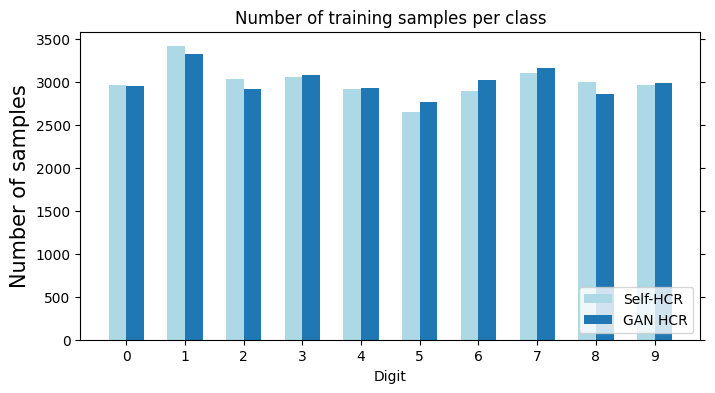

[6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]


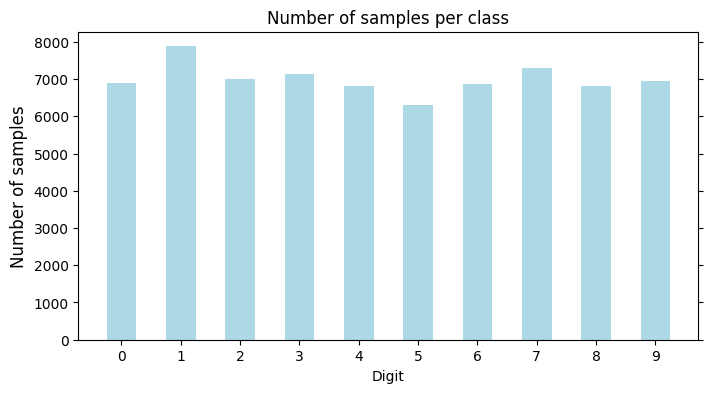

In [52]:
if plot:
	plt.rcParams['figure.figsize'] = [8, 4]
	fig, ax = plt.subplots(nrows=1, ncols=1)

	_, train_counts = np.unique(y_train, return_counts=True)
	_, gan_train_counts = np.unique(gan_y_train, return_counts=True)

	barWidth = 0.3
	br1 = np.arange(len(train_counts)) 
	br2 = [x + barWidth for x in br1] 

	ax.bar(br1, train_counts, width=barWidth, color='lightblue', label="Self-HCR")
	ax.bar(br2, gan_train_counts, width=barWidth, label="GAN HCR")
	# ax.set_xticklabels(labels=[i for i in range(10)])
	ax.tick_params(left = True, right = True , labelleft = True , 
					labelbottom = True, bottom = True) 
	plt.xticks([r + (barWidth/2) for r in range(len(train_counts))], 
			['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
	plt.ylabel('Number of samples', fontsize = 15) 
	plt.xlabel('Digit')
	plt.title('Number of training samples per class')
	plt.legend(loc="lower right")
	plt.savefig('./datavis/classbal_mnist_training.png', dpi=300)
	plt.show()

	plt.rcParams['figure.figsize'] = [8, 4]
	fig, ax = plt.subplots(nrows=1, ncols=1)

	_, total_counts = np.unique(y_total_data, return_counts=True)
	print(total_counts)

	barWidth = 0.5
	br1 = np.arange(len(train_counts)) 

	ax.bar(br1, total_counts, width=barWidth, color='lightblue')
	# ax.set_xticklabels(labels=[i for i in range(10)])
	ax.tick_params(left = True, right = True , labelleft = True , 
					labelbottom = True, bottom = True) 
	plt.xticks([r for r in range(len(train_counts))], 
			['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
	plt.ylabel('Number of samples', fontsize = 12) 
	plt.xlabel('Digit')
	plt.title('Number of samples per class')
	plt.savefig('./datavis/classbal_mnist.png', dpi=300)
	plt.show()


### Checking the data

In [6]:
if plot:
	tsne = TSNE(n_components=2)
	tsne_results = tsne.fit_transform(x_total_data.reshape(x_total_data.shape[0], 28*28))

	# x_train_tsne_results = tsne.fit_transform(x_train.reshape(x_train.shape[0], 28*28))
	# gan_train_tsne_results = tsne.fit_transform(gan_train.reshape(gan_train.shape[0], 28*28))



In [7]:
def plot_tsne(results, y_data, file_name):
	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(results[:,0], results[:,1], c=y_data)
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(y_total_data), prop = { "size": 20 }, loc="upper right")
	plt.title("t-SNE MNIST", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig(file_name, dpi=300)
	plt.show()


In [ ]:
if plot:
	plot_tsne(tsne_results, y_total_data, "./datavis/mnist_tsne.png")
	


In [5]:
if aug:
    x_train_aug = np.array([augment(x) for x in x_train.astype("float32")])
    x_train = np.concatenate([x_train, np.array(x_train_aug)])
    y_train = np.concatenate([y_train, y_train])

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))


x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [6]:
def make_htr_model():
    initializer = tf.keras.initializers.HeUniform(seed=42)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1],  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3, seed=42))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1],  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3, seed=42))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10,  kernel_initializer=initializer))
    model.add(tf.keras.layers.Softmax())
    return model

# Supervised Handwritten character Recognition

In [21]:
super_htr_model = make_htr_model()    
super_htr_model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_120 (LeakyReLU)  (None, 14, 14, 64)       0         
                                                                 
 dropout_80 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_121 (Conv2D)         (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_121 (LeakyReLU)  (None, 7, 7, 64)         0         
                                                                 
 dropout_81 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_122 (Conv2D)         (None, 7, 7, 128)       

In [66]:
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

super_htr_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

res = {}
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    print("Starting fold ", i)
    x_train_fold = [x_train[i] for i in train_index]
    x_valid_fold = [x_train[i] for i in valid_index]

    y_train_fold = [y_train[i] for i in train_index]
    y_valid_fold = [y_train[i] for i in valid_index]

    y_train_fold = tf.keras.utils.to_categorical(y_train_fold, 10)
    y_valid_fold = tf.keras.utils.to_categorical(y_valid_fold, 10)

    dataset = tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
    dataset = dataset.shuffle(buffer_size=1024).batch(256)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid_fold, y_valid_fold))
    val_dataset = val_dataset.batch(256)

    super_htr_model = make_htr_model()    
    super_htr_model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['acc'],
    )
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    res[i] = super_htr_model.fit(dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])
    preds[i] = super_htr_model.predict(x_test)

    super_htr_model.save(f'./mnist_super_hcr_f{i}.keras')

Starting fold  0
Epoch 1/100
94/94 [==============================] - 2s 16ms/step - loss: 0.4803 - acc: 0.8556 - val_loss: 0.2257 - val_acc: 0.9335
Epoch 2/100
94/94 [==============================] - 1s 15ms/step - loss: 0.2011 - acc: 0.9396 - val_loss: 0.1486 - val_acc: 0.9555
Epoch 3/100
94/94 [==============================] - 1s 12ms/step - loss: 0.1429 - acc: 0.9563 - val_loss: 0.1103 - val_acc: 0.9670
Epoch 4/100
94/94 [==============================] - 1s 12ms/step - loss: 0.1155 - acc: 0.9641 - val_loss: 0.1003 - val_acc: 0.9690
Epoch 5/100
94/94 [==============================] - 1s 12ms/step - loss: 0.1008 - acc: 0.9678 - val_loss: 0.0842 - val_acc: 0.9745
Epoch 6/100
94/94 [==============================] - 1s 12ms/step - loss: 0.0916 - acc: 0.9700 - val_loss: 0.0844 - val_acc: 0.9750
Epoch 7/100
94/94 [==============================] - 1s 12ms/step - loss: 0.0826 - acc: 0.9736 - val_loss: 0.0836 - val_acc: 0.9745
Epoch 8/100
94/94 [==============================] - 1s 12m

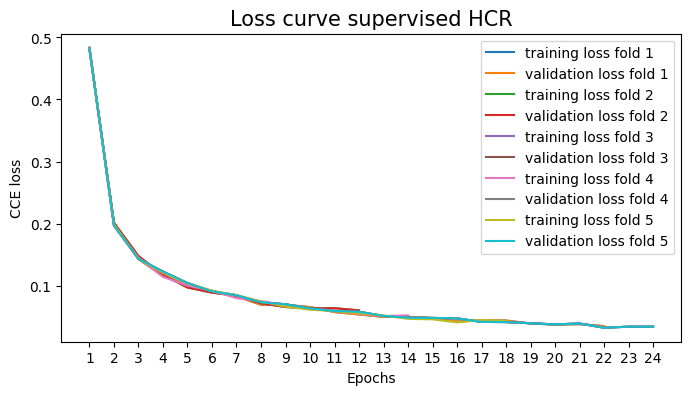

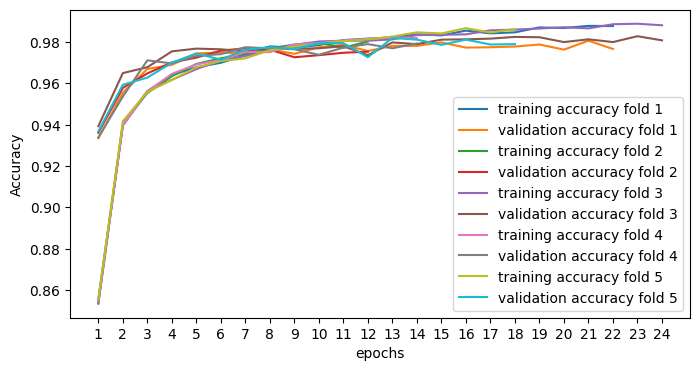

In [67]:
tr_loss = []
val_loss = []

tr_acc = []
val_acc = []

for i in range(len(res.keys())):
	tr_loss.append(list(res[i].history['loss']))
	val_loss.append(list(res[i].history['loss']))

	tr_acc.append(list(res[i].history['acc']))
	val_acc.append(list(res[i].history['val_acc']))


fig = plt.figure(figsize=(8, 4))

max_epochs = max(len(tr_loss[0]), len(tr_loss[1]), len(tr_loss[2]))
plt.plot(np.arange(len(tr_loss[0])), tr_loss[0], label="training loss fold 1")
plt.plot(val_loss[0], label="validation loss fold 1")
plt.plot(np.arange(len(tr_loss[1])),tr_loss[1],  label="training loss fold 2")
plt.plot(val_loss[1], label="validation loss fold 2")
plt.plot(np.arange(len(tr_loss[2])), tr_loss[2],  label="training loss fold 3")
plt.plot(val_loss[2], label="validation loss fold 3")
plt.plot(np.arange(len(tr_loss[3])), tr_loss[3],  label="training loss fold 4")
plt.plot(val_loss[2], label="validation loss fold 4")
plt.plot(np.arange(len(tr_loss[4])), tr_loss[4],  label="training loss fold 5")
plt.plot(val_loss[2], label="validation loss fold 5")
plt.legend()
plt.xticks(np.arange(0, max_epochs), labels = np.arange(1, max_epochs + 1))
plt.title("Loss curve supervised HCR", fontsize=15)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("CCE loss", fontsize=10)
if aug:
	plt.savefig("./results/super_hcr_loss_aug.png", dpi=300)
else:
	plt.savefig("./results/super_hcr_loss.png", dpi=300)
plt.show()


fig = plt.figure(figsize=(8, 4))

max_epochs = max(len(tr_acc[0]), len(tr_acc[1]), len(tr_acc[2]))
plt.plot(np.arange(len(tr_acc[0])), tr_acc[0], label="training accuracy fold 1")
plt.plot(val_acc[0], label="validation accuracy fold 1")
plt.plot(np.arange(len(tr_acc[1])),tr_acc[1],  label="training accuracy fold 2")
plt.plot(val_acc[1], label="validation accuracy fold 2")
plt.plot(np.arange(len(tr_acc[2])), tr_acc[2],  label="training accuracy fold 3")
plt.plot(val_acc[2], label="validation accuracy fold 3")
plt.plot(np.arange(len(tr_acc[3])), tr_acc[3],  label="training accuracy fold 4")
plt.plot(val_acc[3], label="validation accuracy fold 4")
plt.plot(np.arange(len(tr_acc[4])), tr_acc[4],  label="training accuracy fold 5")
plt.plot(val_acc[4], label="validation accuracy fold 5")
plt.legend()
plt.xticks(np.arange(0, max_epochs), labels = np.arange(1, max_epochs + 1))
plt.xlabel("epochs")
plt.ylabel("Accuracy")
if aug:
	plt.savefig("./results/super_hcr_acc_aug.png", dpi=300)
else:
	plt.savefig("./results/super_hcr_acc.png", dpi=300)
plt.show()

Mean tr acc: 0.9848583340644836 std tr acc: 0.0031851028003652506
Mean val acc: 0.9782333374023438 std val acc: 0.001970899496196933
(10000, 10)
Test accuracy: 0.9869


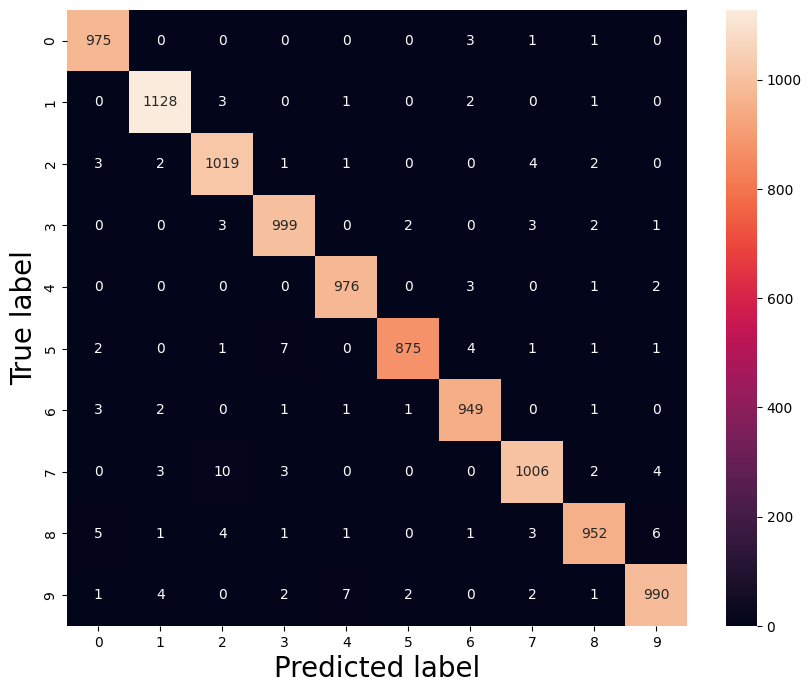

In [70]:
mean_tr_acc = np.mean([res[i].history['acc'][-1] for i in range(len(res.keys()))])
std_tr_acc = np.std([res[i].history['acc'][-1] for i in range(len(res.keys()))])

print("Mean tr acc:", mean_tr_acc, "std tr acc:", std_tr_acc)

mean_val_acc = np.mean([res[i].history['val_acc'][-1] for i in range(len(res.keys()))])
stdval_acc = np.std([res[i].history['val_acc'][-1] for i in range(len(res.keys()))])

print("Mean val acc:", mean_val_acc, "std val acc:", stdval_acc)

y_pred = np.mean([preds[i] for i in range(len(preds.keys()))], axis=0)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1)

accuracy = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

print("Test accuracy:", accuracy)

fig = plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.ylabel("True label", fontsize=20)
plt.xlabel("Predicted label", fontsize=20)
plt.savefig('super_hcr_confmat.png')
plt.show()

# Self-supervised handwritten character recognition

### Plotting vgg features

In [10]:
def get_vgg_model(n_layer, summary=False):
	model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3), pooling=None)
	if summary:
		for num, layer in enumerate(model.layers):
			print(num, layer)
	input_data = tf.keras.Input(shape=(28, 28, 3))
	resized_input = tf.keras.layers.Resizing(32, 32)(input_data)
	desired_layer_output = tf.keras.models.Sequential(model.layers[:n_layer])(resized_input)
	vgg_model = tf.keras.Model(inputs=input_data, outputs=desired_layer_output)
	if summary:
		vgg_model.summary()
	return vgg_model


In [19]:
vgg_model = get_vgg_model(3, summary=True)

0 <keras.engine.input_layer.InputLayer object at 0x000001B1AC430F70>
1 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1E78997E0>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1E7DDBB50>
3 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B1AC39BC70>
4 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1AC430B80>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B198D045B0>
6 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B1E7D968F0>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1DDFF98D0>
8 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1DDFF9000>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1E7D97040>
10 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B1DE0C0880>
11 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1DE0C3A00>
12 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B0014CD210>
13 <keras.layers.co

In [9]:
# x_total_data = np.concatenate([x_train, x_val])
# y_total_data = np.concatenate([np.argmax(y_train, axis=1), np.argmax(y_val, axis=1)])

# print(len(x_total_data))

total_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
total_dataset = total_dataset.shuffle(buffer_size=1024).batch(1024)

# layers = [5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18]
# layers = [12, 13, 14, 16, 17, 18]

# for layer in layers:
layer = 18
print("convolution:", layer)
vgg_features = []
label_batches = []

vgg_model = get_vgg_model(layer)

for batch in total_dataset:
	images, labels = batch
	images_in = tf.concat([images] * 3, axis=-1)
	feats = vgg_model(images_in)
	feats = tf.reshape(feats, [tf.shape(feats)[0], -1]).numpy()
	vgg_features += feats.tolist()
	label_batches += labels.numpy().tolist()

print("computed features, starting tsne...")

if plot:
	tsne = TSNE(n_components=2)
	vgg_tsne_results = tsne.fit_transform(np.array(vgg_features))

	print("Finished tsne dimensionality reduction")

	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(vgg_tsne_results[:,0], vgg_tsne_results[:,1], c=label_batches)
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(label_batches), prop = { "size": 15 }, loc="upper right")
	plt.title(f"Self-HCR dataset vgg features {layer}th convolution", fontsize=20)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig(f"./datavis/selfhcr_vgg_tsne_conv{layer}.png", dpi=300)
	plt.show()


convolution: 18


KeyboardInterrupt: 

In [ ]:
if plot:
	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(vgg_tsne_results[:,0], vgg_tsne_results[:,1], c=label_batches)
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(label_batches), prop = { "size": 20 }, loc="upper right")
	plt.title("Self-HCR dataset vgg features 8th convolution", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	# plt.savefig("./datavis/selfhcr_vgg_tsne_conv8.png", dpi=300)
	plt.show()

### Generator model

In [9]:
mnist_gen = tf.keras.models.load_model("./gan_model/mnist_gan_199.keras")
mnist_gen.summary()

# vgg_model = get_vgg_model(layer)


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6762)              939918    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6762)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 138)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      282752    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

In [7]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [11]:
def save_images(epoch, imgs, labels, pred_labels, true_imgs, loss_dir, layer, plot=False):
    labels_numbers = np.argmax(labels, axis=1)
    pred_labels_numbers = np.argmax(pred_labels, axis=1)

    fig = plt.figure(figsize=(16, 8))
    plot_idx = 1
    print(imgs.shape, true_imgs.shape)
    for i in range(imgs.shape[0]):
        # print(losses[i])
        fig.add_subplot(4, 8, plot_idx )
        pred_str = ""
        # print(pred_labels[i])
        for j in pred_labels[i]:
            pred_str += "," + str(j)[:4]
        if loss_dir != 'vgg':
            plt.imshow(true_imgs[i, :, :] * 255, cmap='gray')
        else:
            plt.imshow(true_imgs[i, :, :, 0] * 255, cmap='gray')
        plt.title(f"gt: {labels_numbers[i]}, \npred: {pred_labels_numbers[i]}\n" + pred_str, fontsize=6.5)
        plt.axis('off')
        fig.add_subplot(4, 8, plot_idx + 1)
        plt.imshow(imgs[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')
 
        plot_idx += 2
    dir_path = './synth_imgs/' + loss_dir +'/'
    if loss_dir == 'vgg':
        dir_path = './synth_imgs/' + loss_dir + '_'+ str(layer) + '/'
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(dir_path + 'images_at_epoch_{:04d}.png'.format(epoch))
    if plot:
        plt.show()
    plt.close()


### Traning Self-HTR

Cross-validation

In [12]:
folds = []
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    print("Starting fold ", i)
    x_train_fold = [x_train[i] for i in train_index]
    x_valid_fold = [x_train[i] for i in valid_index]

    y_train_fold = [y_train[i] for i in train_index]
    y_valid_fold = [y_train[i] for i in valid_index]

    y_train_fold = tf.keras.utils.to_categorical(y_train_fold, 10)
    y_valid_fold = tf.keras.utils.to_categorical(y_valid_fold, 10)

    folds.append((x_train_fold, y_train_fold, x_valid_fold, y_valid_fold))

Starting fold  0
Starting fold  1
Starting fold  2
Starting fold  3
Starting fold  4


training across different vgg layers

In [ ]:


boundaries = [1000, 3000, 5000]
values = [1e-3, 3e-4, 1e-4, 1e-5]

loss_name = 'vgg'
if loss_name == 'vgg':
    layers = [10, 14]
else:
    layers = [0]
    
res_csv = f"./results/self_hcr/{loss_name}.csv"
res_dir = f'./results/self_hcr/'
os.makedirs(res_dir, exist_ok=True)

with open(res_csv, 'w') as res_f:
    for layer in layers:
        vgg_model = get_vgg_model(layer)

        res_dir = f'./results/self_hcr/{loss_name}_{layer}'
        os.makedirs(res_dir, exist_ok=True)
        res = {}

        for fold in range(len(folds)):

            dataset = tf.data.Dataset.from_tensor_slices((folds[fold][0], folds[fold][1]))
            dataset = dataset.shuffle(buffer_size=1024).batch(256)

            val_dataset = tf.data.Dataset.from_tensor_slices((folds[fold][2], folds[fold][3]))
            val_dataset = val_dataset.batch(256)

            htr_model = make_htr_model() 

            # layers = [5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18]

            learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                boundaries, values)

            optimizer = tf.keras.optimizers.Adam(learning_rate_fn, beta_1=0.9)

            m = tf.keras.metrics.Accuracy(
                name="accu",
                dtype=None)

            self_htr = Self_HTR(make_htr_model(), mnist_gen, optimizer, loss_name, layer, latent_dim, m )

            res[fold] = {'epoch_loss':[], 'val_loss': [], 'acc':[], 'val_acc':[]}

            min_val_loss = 1000000
            patience = 5
            pat_count = 1

            for epoch in tqdm(range(100)):
                batch_losses = []
                batch_acc = []
                for batch in dataset:
                    loss, acc = self_htr.train_step(batch)
                    
                    batch_losses.append(loss)
                    batch_acc.append(acc)

                res[fold]['epoch_loss'].append(np.mean(batch_losses))
                res[fold]['acc'].append(np.mean(batch_acc))
                
                val_loss, val_acc, synth_imgs, x_val, y_val, y_preds = self_htr.validate(val_dataset)

                # count patience for early stopping
                if val_loss < min_val_loss: 
                    min_val_loss = val_loss
                    pat_count = 1
                else:
                    pat_count += 1

                save_images(epoch, synth_imgs, y_val, y_preds, x_val, loss_name, layer)
                res[fold]['val_loss'].append(val_loss)
                res[fold]['val_acc'].append(val_acc)
                print(f"epoch: {epoch} loss: {res[fold]['epoch_loss'][epoch]} val_loss: {val_loss} acc: {res[fold]['acc'][epoch]} val_acc: {val_acc}")

                # Early stopping criteria
                if pat_count == patience:
                    break

            np.save(f'{res_dir}/train_losses_epoch_f{fold}.npy', res[fold]['epoch_loss'])
            np.save(f'{res_dir}/train_acc_f{fold}.npy', res[fold]['acc'])
            np.save(f'{res_dir}/validation_losses_f{fold}.npy', res[fold]['val_loss'])
            np.save(f'{res_dir}/validation_acc_f{fold}.npy', res[fold]['val_acc'])

            self_htr.htr_model.save(f'{res_dir}/mnist_super_hcr_f{fold}.keras')

        mean_train_acc = np.mean([res[fold]['acc'][-1] for fold in range(len(folds))])
        std_train_acc = np.std([res[fold]['acc'][-1] for fold in range(len(folds))])
        mean_val_acc = np.mean([res[fold]['val_acc'][-1] for fold in range(len(folds))])
        std_val_acc = np.std([res[fold]['val_acc'][-1] for fold in range(len(folds))])

        res_f.write(f"{loss_name} {layer} {mean_train_acc} {std_train_acc} {mean_val_acc} {std_val_acc}\n")


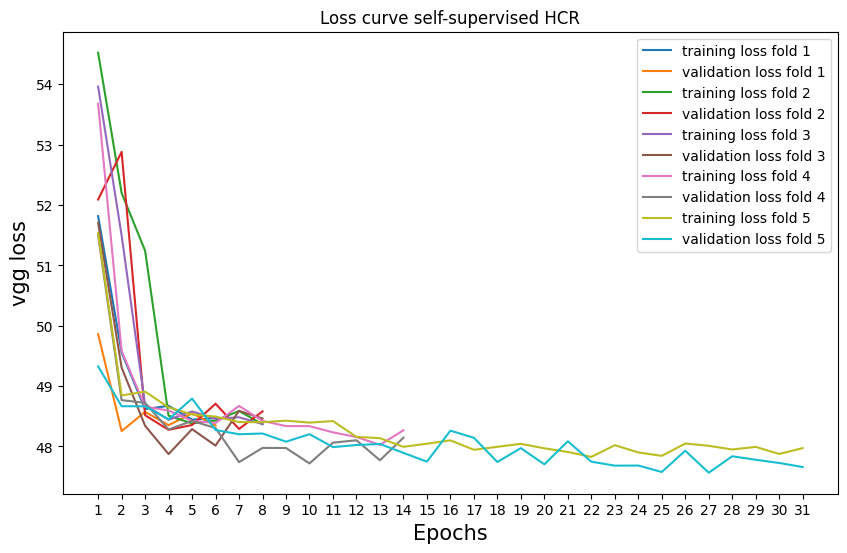

313/313 [==============================] - 0s 1ms/step
(10000, 10)
Test accuracy: 0.9199


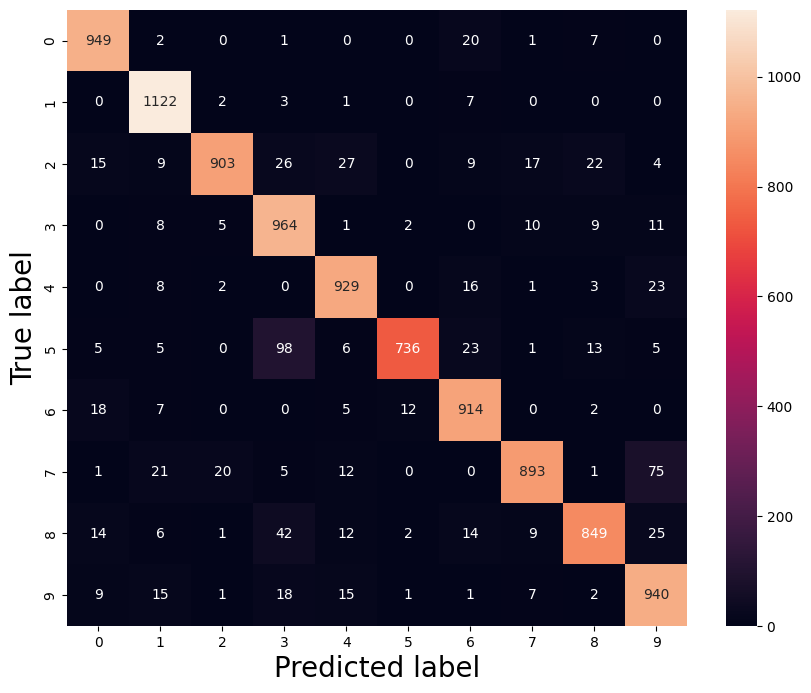

In [13]:
loss_name = 'vgg'

if loss_name == 'vgg':
    layer = 10
else:
    layer = 0
    
res_dir = f"./results/self_hcr/{loss_name}_{layer}"

train_losses = [np.load(res_dir + f'/train_losses_epoch_f{fold}.npy') for fold in range(len(folds))]
val_losses = [np.load(res_dir + f'/validation_losses_f{fold}.npy') for fold in range(len(folds))]

fig = plt.figure(figsize=(10, 6))

max_epochs = max([len(train_losses[i]) for i in range(len(train_losses))])
for i in range(len(train_losses)):
	plt.plot(np.arange(len(train_losses[i])), train_losses[i], label=f"training loss fold {i + 1}")
	plt.plot(val_losses[i], label=f"validation loss fold {i + 1}")
plt.legend()
plt.xticks(np.arange(0, max_epochs), labels = np.arange(1, max_epochs + 1))
plt.xlabel("Epochs", fontsize=15)
plt.title("Loss curve self-supervised HCR")
plt.ylabel(f"{loss_name} loss", fontsize=15)
if aug:
	plt.savefig(f"./results/self_hcr_{loss_name}_loss_aug.png", dpi=300)
else:
	plt.savefig(f"./results/self_hcr_{loss_name}_loss.png", dpi=300)
plt.show()


models = [tf.keras.models.load_model(res_dir + f'/mnist_super_hcr_f{fold}.keras') for fold in range(len(folds))]
preds = [model.predict(x_test) for model in models]

y_pred = np.mean([preds[i] for i in range(len(preds))], axis=0)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1)

accuracy = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

print("Test accuracy:", accuracy)

fig = plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.ylabel("True label", fontsize=20)
plt.xlabel("Predicted label", fontsize=20)
if aug:
	plt.savefig(f"./results/self_hcr_{loss_name}_confmat_aug.png", dpi=300)
else:
	plt.savefig(f"./results/self_hcr_{loss_name}_confmat.png", dpi=300)
plt.show()

In [ ]:

# Make gif
dir_path = './results/vgg/'
os.makedirs(dir_path, exist_ok=True)
with imageio.get_writer(dir_path + '/anims.gif', mode='I') as writer:
    filenames = glob.glob('./synth_imgs/vgg/*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    

FileExistsError: [WinError 183] Kan geen bestand maken dat al bestaat: './results/vgg/'

In [ ]:
data = list(dataset.take(100))
images, one_hot_labels = data[0]

313/313 [==============================] - 0s 1ms/step
(16,)
(16, 28, 28, 1) (16, 28, 28, 1)


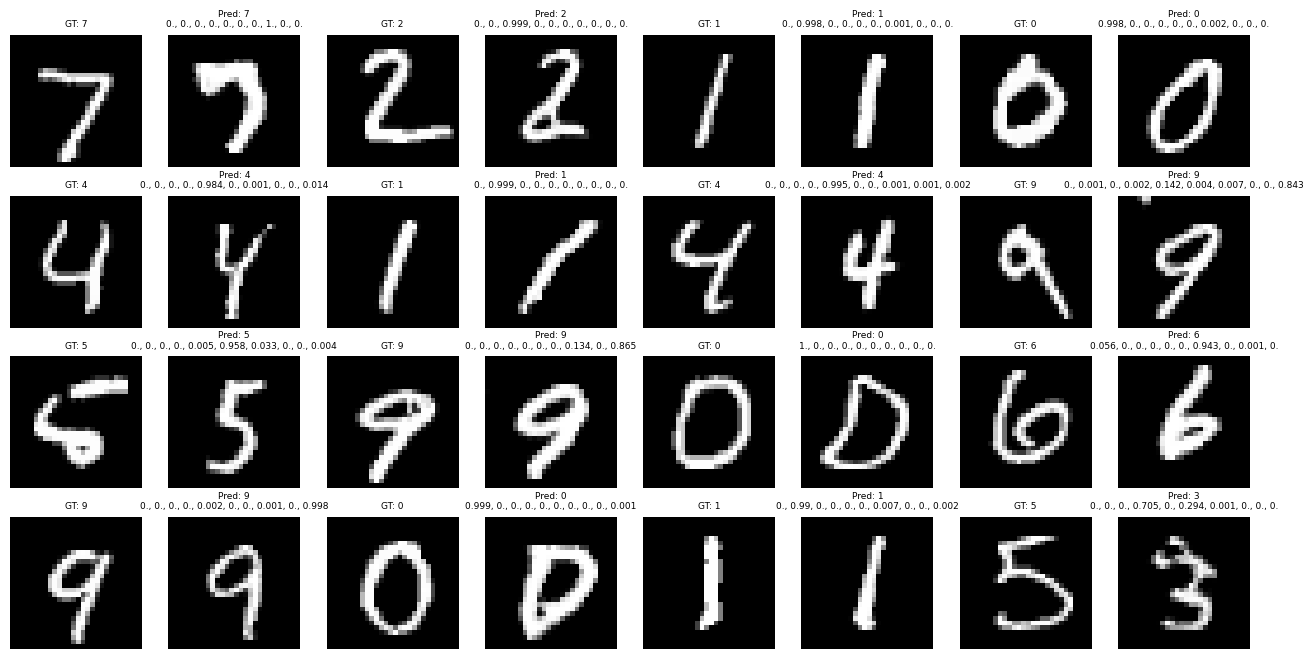

In [45]:

num_imgs = 16

models = [tf.keras.models.load_model(f'./results/self_hcr/vgg_10/mnist_super_hcr_f{fold}.keras') for fold in range(len(folds))]
preds = [model.predict(x_test) for model in models]

y_pred_prob = np.mean([preds[i] for i in range(len(preds))], axis=0)
y_pred_prob = y_pred_prob[:num_imgs]
print(y_pred.shape)

y_pred = np.argmax(y_pred_prob, axis = 1) 
y_true = np.argmax(y_test, axis = 1)
y_true = y_true[:num_imgs]

imgs = x_test[:num_imgs]

random_latent_vectors = tf.random.normal(
    shape=(num_imgs, latent_dim), seed=1337
)
# print(tf.shape(random_latent_vectors))

random_vector_labels = tf.concat(
        [random_latent_vectors, y_pred_prob], axis=1
    )

synth_imgs = mnist_gen(random_vector_labels, training=False)

fig = plt.figure(figsize=(16, 8))
plot_idx = 1
print(synth_imgs.shape, imgs.shape)

np.set_printoptions(precision=3, suppress=True)
for i in range(imgs.shape[0]):
    # print(losses[i])
    fig.add_subplot(4, 8, plot_idx )
    pred_str = ""
    for prob_idx, prob in enumerate(y_pred_prob[i]):
        if prob_idx != 0:
            pred_str += ", " + np.array2string(y_pred_prob[i][prob_idx])
        else:
            pred_str += np.array2string(y_pred_prob[i][prob_idx])
    
    # print(pred_labels[i])
    # for j in y_pred_prob[i]:
    #     pred_str += "," + str(j)[:4]
    plt.imshow(imgs[i, :, :] * 255, cmap='gray')
    # else:
    #     plt.imshow(imgs[i, :, :, 0] * 255, cmap='gray')
    plt.title(f"GT: {y_true[i]}", fontsize=6.5)
    plt.axis('off')
    fig.add_subplot(4, 8, plot_idx + 1)
    plt.title(f"Pred: {y_pred[i]}\n" + pred_str, fontsize=6.5)
    plt.imshow(synth_imgs[i, :, :, 0] * 255, cmap='gray')
    plt.axis('off')

    plot_idx += 2
dir_path = './synth_imgs/vgg_10/'
os.makedirs(dir_path, exist_ok=True)
plt.savefig(dir_path + 'test_images.png')
if plot:
    plt.show()
plt.close()




# Apply supervised HCR on recreated test set

In [60]:
models = [tf.keras.models.load_model(f'./results/self_hcr/bce_0/mnist_super_hcr_f{fold}.keras') for fold in range(len(folds))]

synth_preds = {}
preds = {}

for model_idx, model in enumerate(models):
    preds[model_idx] = []
    synth_preds[model_idx] = []
    for idx in range(10):
        random_latent_vectors = tf.random.normal(
            shape=(1000, latent_dim), seed=1337
        )
        # print(tf.shape(random_latent_vectors))

        random_vector_labels = tf.concat(
                [random_latent_vectors, y_test[idx*1000:(idx+1)*1000]], axis=1
            )

        recreated_test_imgs = mnist_gen(random_vector_labels, training=False)
        
        synth_preds[model_idx] += list(model.predict(recreated_test_imgs))
        preds[model_idx] += list(model.predict(x_test[idx*1000:(idx + 1)*1000]))

print(len(preds[0]))


32/32 [==============================] - 0s 1ms/step
10000


In [61]:
y_pred = np.mean([preds[i] for i in range(len(preds.keys()))], axis=0)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1)

accuracy = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

print("Test accuracy:", accuracy)

y_pred = np.mean([synth_preds[i] for i in range(len(preds.keys()))], axis=0)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1)

accuracy = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

print("Test accuracy:", accuracy)

(10000, 10)
Test accuracy: 0.6244
(10000, 10)
Test accuracy: 0.8135
